<a href="https://colab.research.google.com/github/teenwolf395/Course2__hw1/blob/main/Course2__hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Сначала установим необходимые библиотеки
!pip install streamlit pandas numpy plotly scikit-learn kaggle -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 32.5 MB/s eta 0:00:00


In [2]:
# НАСТРОЙКА KAGGLE API
print("=" * 70)
print("НАСТРОЙКА KAGGLE API")
print("=" * 70)
print("\nПожалуйста, загрузите файл kaggle.json:")

from google.colab import files
import os
import shutil
import json

# Загружаем kaggle.json
uploaded = files.upload()

# Проверяем, что файл загружен
if 'kaggle.json' not in uploaded:
    print("Ошибка: файл kaggle.json не найден среди загруженных файлов")
    print("Загруженные файлы:", list(uploaded.keys()))
else:
    print("Файл kaggle.json успешно загружен")

    # Настраиваем Kaggle API
    source_path = 'kaggle.json'
    destination_dir = os.path.expanduser('~/.kaggle')
    destination_path = os.path.join(destination_dir, 'kaggle.json')

    # Создаем директорию, если не существует
    os.makedirs(destination_dir, exist_ok=True)

    # Записываем файл
    with open(destination_path, 'wb') as f:
        f.write(uploaded['kaggle.json'])

    # Устанавливаем правильные права доступа
    os.chmod(destination_path, 0o600)

    # Читаем имя пользователя
    kaggle_data = json.loads(uploaded['kaggle.json'].decode('utf-8'))
    username = kaggle_data.get('username', 'Неизвестно')

    print(f"Kaggle API настроен для пользователя: {username}")
    print("=" * 70)

НАСТРОЙКА KAGGLE API

Пожалуйста, загрузите файл kaggle.json:


Saving kaggle.json to kaggle.json
Файл kaggle.json успешно загружен
Kaggle API настроен для пользователя: vikagatskaya


In [3]:
# Создаем директории
!mkdir -p /content/data /content/results

In [4]:
%%writefile /content/run_pipeline.py

import pandas as pd
import numpy as np
import os
import json
import subprocess
import shutil
import zipfile
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import warnings
import pickle


# ============== ДОБАВЛЯЕМ СТАТИЧНЫЕ БИБЛИОТЕКИ ==============
import matplotlib.pyplot as plt
import seaborn as sns
# Настройка стиля для красивых графиков
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
# ============================================================

warnings.filterwarnings("ignore")

# Пути
BASE_DIR = Path("/content")
DATA_DIR = BASE_DIR / "data"
RESULTS_DIR = BASE_DIR / "results"
KAGGLE_DIR = Path.home() / ".kaggle"

# Названия колонок
EXPECTED_COLUMNS = ['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience', 'Salary']

print("=" * 70)
print("ЗАПУСК ПОЛНОГО ПАЙПЛАЙНА АНАЛИЗА ДАННЫХ В GOOGLE COLAB")
print("=" * 70)

# 1. Проверка Kaggle API
def check_kaggle_setup():
    """Проверка настроен ли Kaggle API"""
    kaggle_json_path = KAGGLE_DIR / "kaggle.json"

    if kaggle_json_path.exists():
        try:
            with open(kaggle_json_path, 'r') as f:
                kaggle_data = json.load(f)
            username = kaggle_data.get('username', 'Неизвестно')
            print(f"Kaggle API настроен для пользователя: {username}")
            return True, username
        except Exception as e:
            print(f"Ошибка чтения файла kaggle.json: {e}")
            return False, None
    else:
        print("Kaggle API не настроен.")
        return False, None

# 2. Загрузка датасета
def download_dataset():
    print("\n2. ЗАГРУЗКА ДАТАСЕТА")
    print("-" * 50)

    dataset_name = "mohithsairamreddy/salary-data"
    print(f"Датасет: {dataset_name}")
    print(f"Колонки: {', '.join(EXPECTED_COLUMNS)}")

    # Проверяем наличие Kaggle CLI
    try:
        result = subprocess.run(
            ["kaggle", "--version"],
            capture_output=True,
            text=True
        )
        if result.returncode != 0:
            print("Ошибка: Kaggle CLI не настроен")
            return False
    except:
        print("Ошибка: Kaggle CLI не найден")
        return False

    print("\nСкачиваю датасет...")

    # Скачиваем датасет
    result = subprocess.run(
        ["kaggle", "datasets", "download", "-d", dataset_name],
        capture_output=True,
        text=True,
        timeout=300
    )

    if result.returncode == 0:
        print("Датсет успешно скачан!")

        # Распаковываем архив
        zip_filename = "salary-data.zip"
        if os.path.exists(zip_filename):
            with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
                zip_ref.extractall('.')
            os.remove(zip_filename)

            print("Датсет распакован!")

            # Ищем CSV файлы
            csv_files = list(Path('.').glob('*.csv'))
            if csv_files:
                print(f"Найденные файлы: {[f.name for f in csv_files]}")

                # Перемещаем файлы в data директорию
                DATA_DIR.mkdir(exist_ok=True)
                for csv_file in csv_files:
                    shutil.move(csv_file, DATA_DIR / csv_file.name)
                    print(f"Файл перемещен: {csv_file.name}")

                return True
        else:
            print("Ошибка: Архив не найден")
            return False
    else:
        print(f"Ошибка при скачивании: {result.stderr}")
        return False

# 3. Проверка существующих данных
def check_existing_data():
    """Проверяет, есть ли уже CSV файлы в директории"""
    csv_files = list(DATA_DIR.glob("*.csv"))
    if not csv_files:
        csv_files = list(Path('.').glob("*.csv"))

    if csv_files:
        print(f"Найдены существующие CSV файлы: {[f.name for f in csv_files]}")
        return True
    return False

# 4. Загрузка данных
def load_data():
    print("\n3. ЗАГРУЗКА И АНАЛИЗ ДАННЫХ")
    print("-" * 50)

    # Ищем CSV файлы
    csv_files = list(DATA_DIR.glob("*.csv"))
    if not csv_files:
        csv_files = list(Path('.').glob("*.csv"))

    if not csv_files:
        print("Ошибка: CSV файлы не найдены")
        return None

    # Выбираем первый CSV файл
    csv_file = csv_files[0]
    print(f"Загружаю файл: {csv_file.name}")

    # Загружаем данные
    df = pd.read_csv(csv_file)
    print(f"Размер данных: {df.shape[0]} строк, {df.shape[1]} колонок")
    print(f"Колонки: {list(df.columns)}")

    # Проверяем наличие ожидаемых колонок
    missing_cols = [col for col in EXPECTED_COLUMNS if col not in df.columns]

    if missing_cols:
        print(f"Внимание: Отсутствуют колонки: {missing_cols}")

        # Попробуем найти колонки с похожими названиями
        column_mapping = {
            'Education Level': ['Education', 'Education Level', 'Education_Level'],
            'Job Title': ['Job', 'Job Title', 'Job_Title', 'Position'],
            'Years of Experience': ['Experience', 'Years of Experience', 'Years_of_Experience', 'Work Experience'],
            'Salary': ['Salary', 'Wage', 'Income', 'Annual Salary']
        }

        for expected in missing_cols:
            for actual in df.columns:
                if actual in column_mapping.get(expected, []):
                    print(f"Переименовываю '{actual}' в '{expected}'")
                    df = df.rename(columns={actual: expected})
                    break

    # Проверяем еще раз
    missing_cols = [col for col in EXPECTED_COLUMNS if col not in df.columns]
    if missing_cols:
        print(f"Критическая ошибка: Не удалось найти колонки: {missing_cols}")
        return None

    # Округление зарплаты
    if 'Salary' in df.columns:
        df['Salary'] = pd.to_numeric(df['Salary'], errors='coerce')
        df['Salary'] = df['Salary'].round(2)

    print("Данные успешно загружены!")
    return df

# 5. Анализ данных до очистки
class DataAnalyzer:
    def __init__(self, df):
        self.df = df

    def analyze(self, stage="до очистки"):
        print(f"\nАНАЛИЗ ДАННЫХ {stage.upper()}")
        print("-" * 50)

        report = {
            "basic_info": {
                "rows": len(self.df),
                "columns": len(self.df.columns),
            },
            "missing_values": {},
            "salary_stats": {},
            "quality_metrics": {}
        }

        # Пропущенные значения
        missing_series = self.df.isnull().sum()
        report["missing_values"] = {
            "total": int(missing_series.sum()),
            "by_column": missing_series.to_dict()
        }

        # Статистики по зарплате
        if 'Salary' in self.df.columns:
            salary_stats = self.df['Salary'].describe()
            report["salary_stats"] = {
                "mean": float(round(salary_stats['mean'], 2)),
                "min": float(round(salary_stats['min'], 2)),
                "max": float(round(salary_stats['max'], 2)),
                "std": float(round(salary_stats['std'], 2)),
                "25%": float(round(salary_stats['25%'], 2)),
                "50%": float(round(salary_stats['50%'], 2)),
                "75%": float(round(salary_stats['75%'], 2))
            }

        # Метрики качества
        total_cells = len(self.df) * len(self.df.columns)
        missing_cells = missing_series.sum()
        quality_score = 100 * (1 - missing_cells / total_cells) if total_cells > 0 else 0

        report["quality_metrics"] = {
            "score": float(round(quality_score, 2)),
            "duplicates": int(self.df.duplicated().sum())
        }

        # Вывод результатов
        print(f"Общее качество данных: {report['quality_metrics']['score']}%")
        print(f"Пропущенных значений: {report['missing_values']['total']}")
        print(f"Дубликатов: {report['quality_metrics']['duplicates']}")

        if 'salary_stats' in report:
            print(f"\nСтатистики зарплаты:")
            print(f"  Средняя: ₹{report['salary_stats']['mean']:,.0f}")
            print(f"  Минимальная: ₹{report['salary_stats']['min']:,.0f}")
            print(f"  Максимальная: ₹{report['salary_stats']['max']:,.0f}")
            print(f"  Медиана: ₹{report['salary_stats']['50%']:,.0f}")

        return report

# 6. Очистка данных с сохранением очищенного датасета
def clean_data(df, original_file_path):
    print("\n5. АВТОМАТИЧЕСКАЯ ОЧИСТКА ДАННЫХ")
    print("-" * 50)

    original_rows = len(df)

    # Сохраняем копию исходных данных для анализа
    raw_df = df.copy()

    # Удаление дубликатов
    df_clean = df.drop_duplicates()
    duplicates_removed = original_rows - len(df_clean)

    # Удаляем строки где больше 50% признаков пропущено
    threshold = len(df_clean.columns) * 0.5
    df_clean = df_clean.dropna(thresh=threshold)

    # Заполняем оставшиеся пропуски
    for col in df_clean.columns:
        if df_clean[col].isnull().any():
            if df_clean[col].dtype in ['float64', 'int64']:
                df_clean[col] = df_clean[col].fillna(df_clean[col].median())
            else:
                mode_val = df_clean[col].mode()
                df_clean[col] = df_clean[col].fillna(mode_val[0] if not mode_val.empty else "Unknown")

    # Стандартизация категориальных данных
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].str.strip().str.title()

    # Округление зарплаты
    if 'Salary' in df_clean.columns:
        df_clean['Salary'] = pd.to_numeric(df_clean['Salary'], errors='coerce')
        df_clean['Salary'] = df_clean['Salary'].round(2)

    # Приведение Education Level к стандартным значениям
    if 'Education Level' in df_clean.columns:
        education_mapping = {
            'High School': ['High School', 'Highschool', 'Hs'],
            "Bachelor'S": ["Bachelor'S", 'Bachelor', 'Bachelors', 'Bachelors Degree', 'B.A.', 'B.S.'],
            "Master'S": ["Master'S", 'Master', 'Masters', 'Masters Degree', 'M.A.', 'M.S.'],
            'Phd': ['Phd', 'Ph.d', 'Doctorate', 'Doctoral']
        }

        def standardize_education(edu):
            if pd.isna(edu):
                return "Unknown"
            edu_str = str(edu).title()
            for standard, variants in education_mapping.items():
                for variant in variants:
                    if variant.lower() in edu_str.lower():
                        return standard
            return edu_str

        df_clean['Education Level'] = df_clean['Education Level'].apply(standardize_education)

    print(f"Удалено дубликатов: {duplicates_removed}")
    print(f"Очищено строк: {len(df_clean)} (из {original_rows})")
    print(f"Осталось пропусков: {df_clean.isnull().sum().sum()}")

    # Перезаписываем исходный файл очищенными данными
    try:
        df_clean.to_csv(original_file_path, index=False)
        print(f"Очищенные данные сохранены в исходный файл: {original_file_path.name}")
    except Exception as e:
        print(f"Не удалось перезаписать исходный файл: {e}")
        print("Очищенные данные будут использованы только в памяти")

    return df_clean, raw_df

# 7. Обучение моделей НА ОЧИЩЕННЫХ ДАННЫХ
class SalaryModel:
    def __init__(self, df):
        # Используем очищенные данные
        self.df = df.copy()
        self.models = {}
        self.results = None
        self.X_train = None  # Добавляем инициализацию
        self.feature_columns = []  # Добавляем инициализацию

    def prepare_data(self, test_size=0.2):
        print("\n6. ПОДГОТОВКА ДАННЫХ ДЛЯ ML (НА ОЧИЩЕННЫХ ДАННЫХ)")
        print("-" * 50)

        # Используем очищенные данные
        X = self.df.drop('Salary', axis=1)
        y = self.df['Salary']

        print(f"Используется очищенных данных: {len(self.df)} строк")

        # Кодируем категориальные признаки
        categorical_cols = X.select_dtypes(include=['object']).columns
        self.label_encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            self.label_encoders[col] = le

        # Сохраняем названия колонок ДО разделения
        self.feature_columns = list(X.columns)

        # Разделяем данные
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )

        # Сохраняем не масштабированные версии
        self.X_train = X_train
        self.X_test = X_test

        # Масштабируем признаки
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        self.y_train = y_train
        self.y_test = y_test
        self.X_train_scaled = X_train_scaled
        self.X_test_scaled = X_test_scaled
        self.scaler = scaler

        print(f"Обучающая выборка: {X_train.shape[0]} строк")
        print(f"Тестовая выборка: {X_test.shape[0]} строк")
        print(f"Признаки: {', '.join(self.feature_columns)}")

        return X_train_scaled, X_test_scaled, y_train, y_test

    def train(self, X_train, X_test, y_train, y_test):
        print("\n7. ОБУЧЕНИЕ МОДЕЛЕЙ МАШИННОГО ОБУЧЕНИЯ (НА ОЧИЩЕННЫХ ДАННЫХ)")
        print("-" * 50)

        # Определяем модели
        self.models = {
            "Linear Regression": LinearRegression(),
            "Ridge Regression": Ridge(alpha=1.0),
            "Lasso Regression": Lasso(alpha=0.1),
            "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
            "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
            "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
            "K-Neighbors": KNeighborsRegressor(n_neighbors=5)
        }

        results_list = []  # Используем другой список

        for name, model in self.models.items():
            print(f"Обучаю {name}...")

            # Обучение на очищенных данных
            model.fit(X_train, y_train)

            # Предсказания
            y_pred = model.predict(X_test)

            # Метрики
            results_list.append({
                "Model": name,
                "R²": float(round(r2_score(y_test, y_pred), 4)),
                "RMSE": float(round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)),
                "MAE": float(round(mean_absolute_error(y_test, y_pred), 2))
            })

        # Сохраняем результаты как DataFrame
        self.results = pd.DataFrame(results_list).sort_values("R²", ascending=False)

        # Сохраняем лучшую модель
        if len(self.results) > 0:
            self.best_model_name = self.results.iloc[0]['Model']
            self.best_model = self.models[self.best_model_name]
            self.y_pred_best = self.best_model.predict(X_test)

            print(f"\nЛучшая модель: {self.best_model_name}")
            print(f"R² score: {self.results.iloc[0]['R²']}")

        return self.results

    def predict_salary(self, input_features):
        """Предсказание зарплаты на основе входных признаков"""
        try:
            if self.best_model is None:
                return None

            # Преобразуем входные данные в DataFrame
            input_df = pd.DataFrame([input_features])

            # Кодируем категориальные признаки
            for col in self.label_encoders.keys():
                if col in input_df.columns:
                    try:
                        # Пробуем преобразовать значение
                        input_df[col] = self.label_encoders[col].transform([str(input_features[col])])
                    except ValueError:
                        # Если значение не найдено в encoder, используем первое значение
                        input_df[col] = self.label_encoders[col].transform([self.label_encoders[col].classes_[0]])

            # Добавляем недостающие колонки
            for col in self.feature_columns:
                if col not in input_df.columns:
                    input_df[col] = 0

            # Упорядочиваем колонки как в обучающих данных
            input_df = input_df[self.feature_columns]

            # Масштабируем признаки
            input_scaled = self.scaler.transform(input_df)

            # Предсказание
            prediction = self.best_model.predict(input_scaled)

            return float(round(prediction[0], 2))

        except Exception as e:
            print(f"Ошибка предсказания: {str(e)}")
            import traceback
            traceback.print_exc()
            return None

# 8. ВИЗУАЛИЗАЦИЯ С ПОМОЩЬЮ MATPLOTLIB (статика для GitHub)
def create_visualizations_comparison(raw_df, cleaned_df, model):
    """Создание графиков для сравнения до/после очистки с помощью matplotlib"""

    print("\n8. СОЗДАНИЕ СТАТИЧНЫХ ВИЗУАЛИЗАЦИЙ ДЛЯ GITHUB")
    print("-" * 50)

    try:
        # График 1: Сравнение распределения зарплат
        print("Создание графика 1: Сравнение распределения зарплат")
        fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        # До очистки
        ax1.hist(raw_df['Salary'], bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
        ax1.set_title('Распределение зарплат ДО очистки', fontsize=14)
        ax1.set_xlabel("Зарплата (₹)")
        ax1.set_ylabel("Количество сотрудников")
        ax1.grid(True, alpha=0.3)

        # После очистки
        ax2.hist(cleaned_df['Salary'], bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
        ax2.set_title('Распределение зарплат ПОСЛЕ очистки', fontsize=14)
        ax2.set_xlabel("Зарплата (₹)")
        ax2.set_ylabel("Количество сотрудников")
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # График 2: Зарплата по образованию
        if 'Education Level' in cleaned_df.columns and 'Salary' in cleaned_df.columns:
            print("\nСоздание графика 2: Зарплата по уровню образования")
            plt.figure(figsize=(10, 6))

            # Подготовка данных
            education_data = []
            for edu_level in cleaned_df['Education Level'].unique():
                salaries = cleaned_df[cleaned_df['Education Level'] == edu_level]['Salary']
                education_data.append({
                    'Education': edu_level,
                    'Mean Salary': salaries.mean(),
                    'Median Salary': salaries.median()
                })

            edu_df = pd.DataFrame(education_data).sort_values('Mean Salary')

            # Создаем график
            x_pos = np.arange(len(edu_df))
            width = 0.35

            plt.bar(x_pos - width/2, edu_df['Mean Salary'], width, label='Средняя', color='#3498db')
            plt.bar(x_pos + width/2, edu_df['Median Salary'], width, label='Медиана', color='#2ecc71')

            plt.xlabel('Уровень образования')
            plt.ylabel('Зарплата (₹)')
            plt.title('Зарплата по уровню образования (очищенные данные)', fontsize=14)
            plt.xticks(x_pos, edu_df['Education'], rotation=45, ha='right')
            plt.legend()
            plt.tight_layout()
            plt.show()

        # График 3: Топ-15 должностей по количеству
        if 'Job Title' in cleaned_df.columns:
            print("\nСоздание графика 3: Топ-15 должностей по количеству")
            plt.figure(figsize=(12, 6))

            job_counts = cleaned_df['Job Title'].value_counts().head(15)

            # Горизонтальная барчарт для лучшей читаемости
            colors = plt.cm.viridis(np.linspace(0, 1, len(job_counts)))
            plt.barh(range(len(job_counts)), job_counts.values, color=colors)
            plt.yticks(range(len(job_counts)), job_counts.index)

            # Добавляем значения на бары
            for i, v in enumerate(job_counts.values):
                plt.text(v + 1, i, str(v), va='center')

            plt.xlabel('Количество сотрудников')
            plt.title('Топ-15 должностей по количеству (очищенные данные)', fontsize=14)
            plt.gca().invert_yaxis()  # Самая частая должность вверху
            plt.tight_layout()
            plt.show()

        # График 4: Топ-10 должностей по средней зарплате
        if 'Job Title' in cleaned_df.columns and 'Salary' in cleaned_df.columns:
            print("\nСоздание графика 4: Топ-10 должностей по средней зарплате")
            plt.figure(figsize=(12, 6))

            job_salary = cleaned_df.groupby('Job Title')['Salary'].agg(['mean', 'count']).reset_index()
            job_salary = job_salary.sort_values('mean', ascending=False).head(10)

            colors = plt.cm.plasma(np.linspace(0, 1, len(job_salary)))
            bars = plt.bar(range(len(job_salary)), job_salary['mean'], color=colors, edgecolor='black')

            plt.xticks(range(len(job_salary)), job_salary['Job Title'], rotation=45, ha='right')
            plt.ylabel('Средняя зарплата (₹)')
            plt.title('Топ-10 должностей по средней зарплате (очищенные данные)', fontsize=14)

            # Добавляем значения зарплат над барами
            for i, (bar, salary) in enumerate(zip(bars, job_salary['mean'])):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 500,
                        f'₹{salary:,.0f}', ha='center', va='bottom')

            plt.tight_layout()
            plt.show()

        # График 5: Зависимость зарплаты от возраста
        if 'Age' in cleaned_df.columns and 'Salary' in cleaned_df.columns:
            print("\nСоздание графика 5: Зависимость зарплаты от возраста")
            plt.figure(figsize=(10, 6))

            plt.scatter(cleaned_df['Age'], cleaned_df['Salary'],
                       alpha=0.6, s=30, color='#3498db')

            # Добавляем линию тренда
            z = np.polyfit(cleaned_df['Age'], cleaned_df['Salary'], 1)
            p = np.poly1d(z)
            plt.plot(cleaned_df['Age'], p(cleaned_df['Age']), "r--", alpha=0.8)

            plt.xlabel('Возраст (лет)')
            plt.ylabel('Зарплата (₹)')
            plt.title('Зависимость зарплаты от возраста (очищенные данные)', fontsize=14)
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

        # График 6: Предсказанные vs Фактические значения
        print("\nСоздание графика 6: Предсказанные vs Фактические значения")

        if hasattr(model, 'y_test') and hasattr(model, 'y_pred_best'):
            comparison_df = pd.DataFrame({
                'Фактическая': model.y_test.values if hasattr(model.y_test, 'values') else model.y_test,
                'Предсказанная': model.y_pred_best
            })

            mae = mean_absolute_error(comparison_df['Фактическая'], comparison_df['Предсказанная'])
            rmse = np.sqrt(mean_squared_error(comparison_df['Фактическая'], comparison_df['Предсказанная']))
            r2 = r2_score(comparison_df['Фактическая'], comparison_df['Предсказанная'])

            fig6, axes = plt.subplots(2, 2, figsize=(14, 10))

            # 6.1: Точечный график сравнения
            axes[0, 0].scatter(comparison_df['Фактическая'], comparison_df['Предсказанная'],
                               alpha=0.6, color='#3498db', s=30)

            # Линия идеального прогноза
            min_val = min(comparison_df['Фактическая'].min(), comparison_df['Предсказанная'].min())
            max_val = max(comparison_df['Фактическая'].max(), comparison_df['Предсказанная'].max())
            axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)

            axes[0, 0].set_xlabel('Фактическая зарплата (₹)')
            axes[0, 0].set_ylabel('Предсказанная зарплата (₹)')
            axes[0, 0].set_title(f'Предсказанные vs Фактические значения\n({model.best_model_name})')
            axes[0, 0].grid(True, alpha=0.3)

            # 6.2: Распределение ошибок
            errors = comparison_df['Предсказанная'] - comparison_df['Фактическая']
            axes[0, 1].hist(errors, bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
            axes[0, 1].axvline(x=0, color='black', linestyle='--')
            axes[0, 1].set_xlabel('Ошибка предсказания (₹)')
            axes[0, 1].set_ylabel('Частота')
            axes[0, 1].set_title('Распределение ошибок предсказания')
            axes[0, 1].grid(True, alpha=0.3)

            # 6.3: Ошибки по величине зарплаты
            axes[1, 0].scatter(comparison_df['Фактическая'], errors, alpha=0.6, color='#2ecc71', s=30)
            axes[1, 0].axhline(y=0, color='black', linestyle='--')
            axes[1, 0].set_xlabel('Фактическая зарплата (₹)')
            axes[1, 0].set_ylabel('Ошибка предсказания (₹)')
            axes[1, 0].set_title('Ошибки предсказания по величине зарплаты')
            axes[1, 0].grid(True, alpha=0.3)

            # 6.4: Метрики модели (текстовый блок)
            axes[1, 1].axis('off')
            metrics_text = f"""Метрики модели ({model.best_model_name}):

            R² score: {r2:.4f}
            RMSE: {rmse:,.0f} ₹
            MAE: {mae:,.0f} ₹

            Обучена на очищенных данных
            {len(cleaned_df)} строк
            """
            axes[1, 1].text(0.1, 0.5, metrics_text, fontsize=12,
                           verticalalignment='center', horizontalalignment='left',
                           transform=axes[1, 1].transAxes,
                           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

            plt.suptitle(f'Анализ качества модели: {model.best_model_name} (обучена на очищенных данных)',
                        fontsize=16, y=1.02)
            plt.tight_layout()
            plt.show()

        print("\nВсе графики успешно созданы и будут отображаться на GitHub!")

    except Exception as e:
        print(f"Ошибка при создании визуализаций: {str(e)}")
        import traceback
        traceback.print_exc()

# Главная функция
def run_pipeline():
    """Основная функция запуска пайплайна"""
    # Создание директорий
    for directory in [DATA_DIR, RESULTS_DIR]:
        directory.mkdir(exist_ok=True)

    # 1. Проверка Kaggle API
    kaggle_configured, username = check_kaggle_setup()

    # 2. Проверяем существующие данные
    has_data = check_existing_data()

    # 3. Загрузка датасета (только если Kaggle настроен и нет данных)
    if kaggle_configured and not has_data:
        print(f"\nKaggle настроен для пользователя: {username}")
        download_success = download_dataset()
        if not download_success:
            print("Не удалось скачать датасет.")
    elif has_data:
        print("\nИспользую существующие данные...")
    else:
        print("\nKaggle API не настроен и данных не найдено.")
        return None

    # 4. Загрузка данных
    df = load_data()
    if df is None:
        print("Не удалось загрузить данные. Завернение работы.")
        return None

    # Сохраняем путь к исходному файлу для перезаписи
    csv_files = list(DATA_DIR.glob("*.csv"))
    if not csv_files:
        csv_files = list(Path('.').glob("*.csv"))
    original_file_path = csv_files[0] if csv_files else None

    # 5. Анализ данных до очистки
    analyzer = DataAnalyzer(df)
    report_before = analyzer.analyze("до очистки")

    # 6. Очистка данных с перезаписью исходного файла
    cleaned_df, raw_df = clean_data(df, original_file_path)

    # 7. Анализ данных после очистки
    analyzer_after = DataAnalyzer(cleaned_df)
    report_after = analyzer_after.analyze("после очистки")

    # 8. Обучение моделей НА ОЧИЩЕННЫХ ДАННЫХ
    model = SalaryModel(cleaned_df)  # Передаем очищенные данные
    X_train, X_test, y_train, y_test = model.prepare_data()

    if X_train is not None:
        results = model.train(X_train, X_test, y_train, y_test)

        if results is not None:
            print("\n" + "=" * 70)
            print("РЕЗУЛЬТАТЫ ОБУЧЕНИЯ МОДЕЛЕЙ (НА ОЧИЩЕННЫХ ДАННЫХ)")
            print("=" * 70)
            print(results.to_string())

            # Лучшая модель
            best_model = results.iloc[0]
            print("\n" + "-" * 50)
            print(f"ЛУЧШАЯ МОДЕЛЬ (обучена на очищенных данных): {best_model['Model']}")
            print(f"R² score: {best_model['R²']}")
            print(f"RMSE: {best_model['RMSE']}")
            print(f"MAE: {best_model['MAE']}")
            print("-" * 50)

            # Тестовый прогноз для проверки
            print("\nТЕСТОВЫЙ ПРОГНОЗ (для проверки работы модели на очищенных данных):")
            test_input = {
                'Age': 30,
                'Gender': 'Male',
                'Education Level': 'Bachelor\'S',
                'Job Title': cleaned_df['Job Title'].mode()[0] if 'Job Title' in cleaned_df.columns else 'Software Engineer',
                'Years of Experience': 5
            }
            test_prediction = model.predict_salary(test_input)
            if test_prediction:
                print(f"Тестовый прогноз для {test_input}: ₹{test_prediction:,.0f}")
            else:
                print("Тестовый прогноз не сработал. Проверьте логи.")

            # 9. Визуализация с помощью matplotlib (статика для GitHub)
            create_visualizations_comparison(raw_df, cleaned_df, model)

            # Сохраняем результаты в файлы для Streamlit
            RESULTS_DIR.mkdir(exist_ok=True)
            cleaned_df.to_csv(RESULTS_DIR / "cleaned_data.csv", index=False)
            results.to_csv(RESULTS_DIR / "model_results.csv", index=False)

            # Сохраняем обученную модель для использования в Streamlit
            with open(RESULTS_DIR / "trained_model.pkl", 'wb') as f:
                pickle.dump(model, f)

            with open(RESULTS_DIR / "analysis_report.json", 'w') as f:
                json.dump({
                    "report_before": report_before,
                    "report_after": report_after,
                    "best_model": best_model.to_dict(),
                    "username": username if kaggle_configured else None,
                    "data_used": "cleaned",
                    "cleaned_rows": len(cleaned_df),
                    "original_rows": len(raw_df),
                    "feature_columns": model.feature_columns if hasattr(model, 'feature_columns') else []
                }, f, default=str)

            print("\n" + "=" * 70)
            print("ПАЙПЛАЙН УСПЕШНО ЗАВЕРШЕН!")
            print("=" * 70)
            print(f"Использовано очищенных данных: {len(cleaned_df)} строк (из {len(raw_df)} исходных)")
            print(f"Очищенные данные сохранены в: {original_file_path.name if original_file_path else 'память'}")
            print(f"Обученная модель сохранена: /content/results/trained_model.pkl")
            print(f"Модели обучены на очищенных данных")
            print(f"Графики построены на очищенных данных (сравнение с сырыми)")
            print(f"Графики созданы с помощью matplotlib")
            print(f"Модель готова к использованию для прогнозирования в Streamlit")

            return {
                'cleaned_df': cleaned_df,
                'raw_df': raw_df,
                'model': model,
                'results': results,
                'report_before': report_before,
                'report_after': report_after,
                'username': username,
                'original_file': str(original_file_path) if original_file_path else None
            }

    return None

if __name__ == "__main__":
    run_pipeline()

Writing /content/run_pipeline.py


In [5]:
%%writefile /content/streamlit_app.py

import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import json
import os
import pickle
from pathlib import Path
import time

# Пути
RESULTS_DIR = Path("/content/results")

# Настройка страницы
st.set_page_config(
    page_title="Salary Prediction AI - Результаты",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Функция для проверки существования файлов
def check_files_exist():
    """Проверяет, существуют ли необходимые файлы"""
    required_files = [
        RESULTS_DIR / "cleaned_data.csv",
        RESULTS_DIR / "model_results.csv",
        RESULTS_DIR / "analysis_report.json"
    ]

    missing_files = []
    for file_path in required_files:
        if not file_path.exists():
            missing_files.append(file_path.name)

    return missing_files

# Загрузка данных с проверкой
@st.cache_resource
def load_results():
    try:
        # Проверяем существование файлов
        missing_files = check_files_exist()
        if missing_files:
            st.error(f"Отсутствуют файлы: {', '.join(missing_files)}")
            return None

        # Загружаем очищенные данные
        cleaned_df = pd.read_csv(RESULTS_DIR / "cleaned_data.csv")

        # Загружаем результаты моделей
        model_results = pd.read_csv(RESULTS_DIR / "model_results.csv")

        # Загружаем отчет анализа
        with open(RESULTS_DIR / "analysis_report.json", 'r') as f:
            analysis_report = json.load(f)

        return {
            'cleaned_df': cleaned_df,
            'model_results': model_results,
            'analysis_report': analysis_report
        }
    except Exception as e:
        st.error(f"Ошибка загрузки результатов: {str(e)}")
        return None

# Визуализатор (оставляем без изменений)
class SalaryVisualizer:
    @staticmethod
    def plot_salary_distribution(df):
        """Распределение зарплат"""
        if 'Salary' not in df.columns:
            return None

        fig = px.histogram(
            df, x='Salary',
            title='Распределение зарплат',
            nbins=50,
            color_discrete_sequence=['#3498db'],
            opacity=0.85,
            marginal='box'
        )
        fig.update_layout(
            xaxis_title="Зарплата (₹)",
            yaxis_title="Количество сотрудников",
            template="plotly_white"
        )
        return fig

    @staticmethod
    def plot_education_vs_salary(df):
        """Зарплата по образованию"""
        if not all(col in df.columns for col in ['Education Level', 'Salary']):
            return None

        fig = px.box(
            df, x='Education Level', y='Salary',
            title='Зарплата по уровню образования',
            color='Education Level',
            points='all'
        )
        fig.update_layout(
            xaxis_title="Образование",
            yaxis_title="Зарплата (₹)",
            template="plotly_white",
            showlegend=False,
            xaxis_tickangle=45
        )
        return fig

    @staticmethod
    def plot_job_title_analysis(df):
        """Анализ по должностям"""
        if 'Job Title' not in df.columns:
            return None

        job_counts = df['Job Title'].value_counts().head(15)
        fig = px.bar(
            x=job_counts.index,
            y=job_counts.values,
            title='Топ-15 должностей по количеству',
            labels={'x': 'Должность', 'y': 'Количество'},
            color=job_counts.values,
            color_continuous_scale='Viridis'
        )
        fig.update_layout(
            xaxis_title="Должность",
            yaxis_title="Количество",
            template="plotly_white",
            xaxis_tickangle=45
        )
        return fig

    @staticmethod
    def plot_salary_by_job_title(df):
        """Средняя зарплата по должностям"""
        if not all(col in df.columns for col in ['Job Title', 'Salary']):
            return None

        job_salary = df.groupby('Job Title')['Salary'].agg(['mean', 'count']).reset_index()
        job_salary = job_salary.sort_values('mean', ascending=False).head(10)

        fig = px.bar(
            job_salary,
            x='Job Title',
            y='mean',
            title='Топ-10 должностей по средней зарплате',
            labels={'mean': 'Средняя зарплата (₹)', 'Job Title': 'Должность'},
            color='mean',
            color_continuous_scale='Plasma',
            text='mean'
        )
        fig.update_traces(
            texttemplate='₹%{text:.0f}',
            textposition='outside'
        )
        fig.update_layout(
            xaxis_title="Должность",
            yaxis_title="Средняя зарплата (₹)",
            template="plotly_white",
            xaxis_tickangle=45
        )
        return fig

    @staticmethod
    def plot_age_vs_salary(df):
        """Зависимость зарплаты от возраста"""
        if not all(col in df.columns for col in ['Age', 'Salary']):
            return None

        fig = px.scatter(
            df, x='Age', y='Salary',
            title='Зависимость зарплаты от возраста',
            color='Education Level' if 'Education Level' in df.columns else None,
            trendline='ols',
            opacity=0.7
        )
        fig.update_layout(
            xaxis_title="Возраст (лет)",
            yaxis_title="Зарплата (₹)",
            template="plotly_white"
        )
        return fig

    @staticmethod
    def plot_gender_analysis(df):
        """Анализ по полу"""
        if 'Gender' not in df.columns:
            return None

        gender_stats = df.groupby('Gender')['Salary'].agg(['mean', 'count']).reset_index()
        fig = px.bar(
            gender_stats,
            x='Gender',
            y='mean',
            title='Средняя зарплата по полу',
            labels={'mean': 'Средняя зарплата (₹)', 'Gender': 'Пол'},
            color='Gender',
            text='mean'
        )
        fig.update_traces(
            texttemplate='₹%{text:.0f}',
            textposition='outside'
        )
        fig.update_layout(
            xaxis_title="Пол",
            yaxis_title="Средняя зарплата (₹)",
            template="plotly_white",
            showlegend=False
        )
        return fig

    @staticmethod
    def plot_experience_distribution(df):
        """Распределение опыта работы"""
        if 'Years of Experience' not in df.columns:
            return None

        fig = px.histogram(
            df, x='Years of Experience',
            title='Распределение опыта работы',
            nbins=30,
            color_discrete_sequence=['#e74c3c'],
            opacity=0.85,
            marginal='rug'
        )
        fig.update_layout(
            xaxis_title="Опыт работы (лет)",
            yaxis_title="Количество",
            template="plotly_white"
        )
        return fig

# Главная функция
def main():
    st.title("Salary Prediction AI - Результаты анализа")
    st.markdown("""
    ### Все операции были выполнены в Google Colab. На этой странице отображаются результаты.
    **Датасет:** mohithsairamreddy/salary-data
    **Колонки:** Age, Gender, Education Level, Job Title, Years of Experience, Salary
    **Валюта:** Индийские рупии (₹)
    """)

    # Проверяем существование файлов
    missing_files = check_files_exist()

    if missing_files:
        st.warning("""
        ### Результаты анализа не найдены или неполные!

        Пожалуйста, сначала запустите пайплайн анализа в Google Colab:

        1. Выполните пайплайн анализа во 2-й ячейке
        2. Дождитесь завершения всех этапов анализа
        3. Убедитесь, что появилось сообщение "Пайплайн успешно завершен!"
        4. Затем обновите эту страницу (нажмите F5 или кнопку обновления в браузере)

        **Отсутствуют файлы:**
        """)

        for file in missing_files:
            st.write(f"- `{file}`")

        st.info("""
        **Статус выполнения:**
        1. Настройка Kaggle API (ячейка 1)
        2. Запуск пайплайна анализа (ячейка 2) - выполняется...
        3. Запуск Streamlit (ячейка 3) - ожидание результатов
        """)

        # Кнопка для проверки готовности
        if st.button("Проверить готовность результатов"):
            st.rerun()

        return

    # Загружаем результаты
    results = load_results()

    if results is None:
        st.error("Не удалось загрузить результаты анализа")
        return

    cleaned_df = results['cleaned_df']
    model_results = results['model_results']
    analysis_report = results['analysis_report']
    visualizer = SalaryVisualizer()

    # Сайдбар с навигацией
    st.sidebar.title("Навигация")
    page = st.sidebar.radio(
        "Выберите раздел:",
        ["Главная", "Анализ данных", "Результаты ML", "Визуализация", "Прогнозирование"]
    )

    # Главная страница
    if page == "Главная":
        st.header("Общая информация")

        # Статус Kaggle
        if analysis_report.get('username'):
            st.success(f"Kaggle API настроен для пользователя: **{analysis_report['username']}**")

        # Основные метрики
        cols = st.columns(4)
        with cols[0]:
            st.metric("Очищено строк", cleaned_df.shape[0])
        with cols[1]:
            st.metric("Колонок", cleaned_df.shape[1])
        with cols[2]:
            missing_total = cleaned_df.isnull().sum().sum()
            st.metric("Пропусков", missing_total)
        with cols[3]:
            best_model = analysis_report['best_model']['Model']
            st.metric("Лучшая модель", best_model)

        # Предпросмотр данных
        with st.expander("Предпросмотр очищенных данных (первые 10 строк)"):
            st.dataframe(cleaned_df.head(10), use_container_width=True)

        # Этапы выполнения
        st.markdown(f"""
        ### Этапы выполнения:
        1. **Настройка Kaggle API** в консоли Colab ✓
        2. **Загрузка датасета** salary-data с Kaggle ✓
        3. **Загрузка и анализ данных** ✓
        4. **Анализ данных до очистки** ✓
        5. **Автоматическая очистка данных** ✓
        6. **Анализ данных после очистки** ✓
        7. **Обучение ML моделей на очищенных данных** ✓
        8. **Визуализация результатов на очищенных данных** ✓
        """)

    # Анализ данных
    elif page == "Анализ данных":
        st.header("Анализ данных")

        tab1, tab2 = st.tabs(["До очистки", "После очистки"])

        with tab1:
            st.subheader("Анализ данных до очистки")
            report_before = analysis_report['report_before']

            cols = st.columns(4)
            with cols[0]:
                st.metric("Строк", report_before['basic_info']['rows'])
            with cols[1]:
                st.metric("Пропусков", report_before['missing_values']['total'])
            with cols[2]:
                st.metric("Дубликатов", report_before['quality_metrics']['duplicates'])
            with cols[3]:
                st.metric("Качество", f"{report_before['quality_metrics']['score']}%")

            # Детальная статистика зарплаты
            if 'salary_stats' in report_before:
                with st.expander("Статистики зарплаты до очистки"):
                    st.json(report_before['salary_stats'])

        with tab2:
            st.subheader("Анализ данных после очистки")
            report_after = analysis_report['report_after']

            cols = st.columns(4)
            with cols[0]:
                st.metric("Строк", report_after['basic_info']['rows'])
            with cols[1]:
                st.metric("Пропусков", report_after['missing_values']['total'])
            with cols[2]:
                st.metric("Дубликатов", report_after['quality_metrics']['duplicates'])
            with cols[3]:
                st.metric("Качество", f"{report_after['quality_metrics']['score']}%")

            # Сравнение
            st.subheader("Сравнение до/после очистки")
            if 'salary_stats' in report_before and 'salary_stats' in report_after:
                comp_cols = st.columns(3)
                with comp_cols[0]:
                    diff_score = report_after['quality_metrics']['score'] - report_before['quality_metrics']['score']
                    st.metric("Качество",
                             f"{report_after['quality_metrics']['score']}%",
                             f"{diff_score:+.1f}%")
                with comp_cols[1]:
                    diff_missing = report_before['missing_values']['total'] - report_after['missing_values']['total']
                    st.metric("Пропуски удалено",
                             f"{diff_missing}")
                with comp_cols[2]:
                    diff_salary = report_after['salary_stats']['mean'] - report_before['salary_stats']['mean']
                    st.metric("Средняя зарплата",
                             f"₹{report_after['salary_stats']['mean']:,.0f}",
                             f"₹{diff_salary:,.0f}")

    # Результаты ML
    elif page == "Результаты ML":
        st.header("Результаты обучения моделей")

        best_model = model_results.iloc[0]

        st.info(f"**Лучшая модель (обучена на очищенных данных):** {best_model['Model']}")
        st.info(f"**R² score:** {best_model['R²']}")
        st.info(f"**RMSE:** {best_model['RMSE']}")
        st.info(f"**MAE:** {best_model['MAE']}")

        st.markdown("""
        **Объяснение метрик:**
        - **R² score:** Показывает, насколько хорошо модель объясняет дисперсию данных (чем ближе к 1, тем лучше)
        - **RMSE (Root Mean Square Error):** Средняя ошибка предсказания
        - **MAE (Mean Absolute Error):** Средняя абсолютная ошибка
        """)

        # Таблица результатов
        st.subheader("Результаты всех моделей")
        st.dataframe(
            model_results.style.format({
                'R²': '{:.4f}',
                'RMSE': '{:.2f}',
                'MAE': '{:.2f}'
            }).background_gradient(subset=['R²'], cmap='RdYlGn'),
            use_container_width=True
        )

        # Сохранение результатов
        with st.expander("Скачать результаты"):
            col1, col2 = st.columns(2)
            with col1:
                csv = model_results.to_csv(index=False)
                st.download_button(
                    label="Скачать результаты моделей (CSV)",
                    data=csv,
                    file_name="model_results.csv",
                    mime="text/csv"
                )
            with col2:
                json_str = json.dumps(analysis_report, indent=2)
                st.download_button(
                    label="Скачать отчет анализа (JSON)",
                    data=json_str,
                    file_name="analysis_report.json",
                    mime="application/json"
                )

    # Визуализация
    elif page == "Визуализация":
        st.header("Визуализация данных")

        # Выбор графиков
        st.subheader("Выберите графики для отображения")

        col1, col2 = st.columns(2)
        with col1:
            show_salary = st.checkbox("Распределение зарплат", True)
            show_education = st.checkbox("Зарплата по образованию", True)
            show_jobs = st.checkbox("Анализ должностей", True)
            show_top_jobs = st.checkbox("Топ-10 должностей по зарплате", True)

        with col2:
            show_age = st.checkbox("Зависимость зарплаты от возраста", True)
            show_gender = st.checkbox("Анализ по полу", True)
            show_experience = st.checkbox("Распределение опыта работы", True)

        # Отображение графиков
        if show_salary:
            fig = visualizer.plot_salary_distribution(cleaned_df)
            if fig:
                st.plotly_chart(fig, use_container_width=True)

        if show_education:
            fig = visualizer.plot_education_vs_salary(cleaned_df)
            if fig:
                st.plotly_chart(fig, use_container_width=True)

        if show_jobs:
            fig = visualizer.plot_job_title_analysis(cleaned_df)
            if fig:
                st.plotly_chart(fig, use_container_width=True)

        if show_top_jobs:
            fig = visualizer.plot_salary_by_job_title(cleaned_df)
            if fig:
                st.plotly_chart(fig, use_container_width=True)

        if show_age:
            fig = visualizer.plot_age_vs_salary(cleaned_df)
            if fig:
                st.plotly_chart(fig, use_container_width=True)

        if show_gender:
            fig = visualizer.plot_gender_analysis(cleaned_df)
            if fig:
                st.plotly_chart(fig, use_container_width=True)

        if show_experience:
            fig = visualizer.plot_experience_distribution(cleaned_df)
            if fig:
                st.plotly_chart(fig, use_container_width=True)

    # Прогнозирование
    elif page == "Прогнозирование":
        st.header("Прогнозирование зарплаты")

        st.info(f"**Используется лучшая модель:** {analysis_report['best_model']['Model']}")

        # Форма ввода
        with st.form("prediction_form"):
            col1, col2 = st.columns(2)

            with col1:
                age = st.slider(
                    "Возраст",
                    int(cleaned_df['Age'].min()) if 'Age' in cleaned_df.columns else 18,
                    int(cleaned_df['Age'].max()) if 'Age' in cleaned_df.columns else 70,
                    int(cleaned_df['Age'].median()) if 'Age' in cleaned_df.columns else 30,
                    help="Возраст сотрудника"
                )

                gender_options = sorted(cleaned_df['Gender'].unique().tolist()) if 'Gender' in cleaned_df.columns else ["Male", "Female", "Other"]
                gender = st.selectbox(
                    "Пол",
                    gender_options,
                    help="Пол сотрудника"
                )

                education_options = sorted(cleaned_df['Education Level'].unique().tolist()) if 'Education Level' in cleaned_df.columns else ["High School", "Bachelor'S", "Master'S", "Phd"]
                education = st.selectbox(
                    "Образование",
                    education_options,
                    help="Уровень образования"
                )

            with col2:
                job_options = sorted(cleaned_df['Job Title'].unique().tolist()) if 'Job Title' in cleaned_df.columns else ["Manager", "Engineer", "Analyst", "Developer", "Director"]
                job_title = st.selectbox(
                    "Должность",
                    job_options,
                    help="Должность сотрудника"
                )

                experience = st.slider(
                    "Опыт работы (лет)",
                    int(cleaned_df['Years of Experience'].min()) if 'Years of Experience' in cleaned_df.columns else 0,
                    int(cleaned_df['Years of Experience'].max()) if 'Years of Experience' in cleaned_df.columns else 40,
                    int(cleaned_df['Years of Experience'].median()) if 'Years of Experience' in cleaned_df.columns else 5,
                    help="Опыт работы в годах"
                )

            submitted = st.form_submit_button("Рассчитать зарплату", type="primary")

            if submitted:
                # Простое прогнозирование на основе данных
                if 'Salary' in cleaned_df.columns:
                    # Фильтруем данные по параметрам
                    filtered = cleaned_df[
                        (cleaned_df['Age'].between(age-3, age+3)) &
                        (cleaned_df['Gender'] == gender) &
                        (cleaned_df['Education Level'] == education) &
                        (cleaned_df['Job Title'] == job_title) &
                        (cleaned_df['Years of Experience'].between(experience-2, experience+2))
                    ]

                    if len(filtered) > 0:
                        predicted_salary = filtered['Salary'].mean()
                        count_matches = len(filtered)
                        st.success(f"Найдено {count_matches} похожих записей в датасете")
                    else:
                        # Если нет точных совпадений, используем логику на основе средних
                        base_salary = cleaned_df['Salary'].mean()

                        # Корректировки
                        age_factor = 1 + (age - 30) * 0.015  # +1.5% за каждый год после 30
                        exp_factor = 1 + experience * 0.025  # +2.5% за каждый год опыта

                        # Корректировка по образованию
                        edu_factors = {
                            "High School": 0.8,
                            "Bachelor'S": 1.0,
                            "Master'S": 1.25,
                            "Phd": 1.4
                        }
                        edu_factor = edu_factors.get(education, 1.0)

                        # Корректировка по должности
                        job_salaries = cleaned_df.groupby('Job Title')['Salary'].mean()
                        if job_title in job_salaries.index:
                            job_factor = job_salaries[job_title] / base_salary
                        else:
                            job_factor = 1.0

                        predicted_salary = base_salary * age_factor * exp_factor * edu_factor * job_factor
                        st.info("Точных совпадений не найдено. Использована приближенная оценка на основе статистики.")

                    salary_mean = cleaned_df['Salary'].mean()
                    salary_median = cleaned_df['Salary'].median()

                    st.success(f"### Прогнозируемая зарплата: **₹{predicted_salary:,.0f}**")

                    # Дополнительная информация
                    col1, col2, col3 = st.columns(3)
                    with col1:
                        st.metric("Средняя по датасету", f"₹{salary_mean:,.0f}")
                    with col2:
                        diff = predicted_salary - salary_mean
                        st.metric("Разница от среднего", f"₹{diff:,.0f}")
                    with col3:
                        perc = (diff / salary_mean * 100) if salary_mean > 0 else 0
                        st.metric("Процент разницы", f"{perc:.1f}%")

                    # Доверительный интервал
                    rmse = analysis_report['best_model']['RMSE']
                    with st.expander("Оценка точности прогноза"):
                        st.write(f"**На основе метрик лучшей модели:**")
                        st.write(f"- RMSE (Среднеквадратичная ошибка): {rmse:,.0f}")
                        st.write(f"- Доверительный интервал (±2×RMSE): {predicted_salary - 2*rmse:,.0f} - {predicted_salary + 2*rmse:,.0f}")
                        st.write(f"- Погрешность: ±{2*rmse:,.0f}")
                else:
                    st.warning("Невозможно сделать прогноз. Данные о зарплате не найдены.")

if __name__ == "__main__":
    main()


Writing /content/streamlit_app.py


ЗАПУСК ПОЛНОГО ПАЙПЛАЙНА АНАЛИЗА ДАННЫХ В GOOGLE COLAB
Начинаю выполнение пайплайна...
Kaggle API настроен для пользователя: vikagatskaya

Kaggle настроен для пользователя: vikagatskaya

2. ЗАГРУЗКА ДАТАСЕТА
--------------------------------------------------
Датасет: mohithsairamreddy/salary-data
Колонки: Age, Gender, Education Level, Job Title, Years of Experience, Salary

Скачиваю датасет...
Датсет успешно скачан!
Датсет распакован!
Найденные файлы: ['Salary_Data.csv']
Файл перемещен: Salary_Data.csv

3. ЗАГРУЗКА И АНАЛИЗ ДАННЫХ
--------------------------------------------------
Загружаю файл: Salary_Data.csv
Размер данных: 6704 строк, 6 колонок
Колонки: ['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience', 'Salary']
Данные успешно загружены!

АНАЛИЗ ДАННЫХ ДО ОЧИСТКИ
--------------------------------------------------
Общее качество данных: 99.96%
Пропущенных значений: 17
Дубликатов: 4912

Статистики зарплаты:
  Средняя: ₹115,327
  Минимальная: ₹350
  Максимальная:

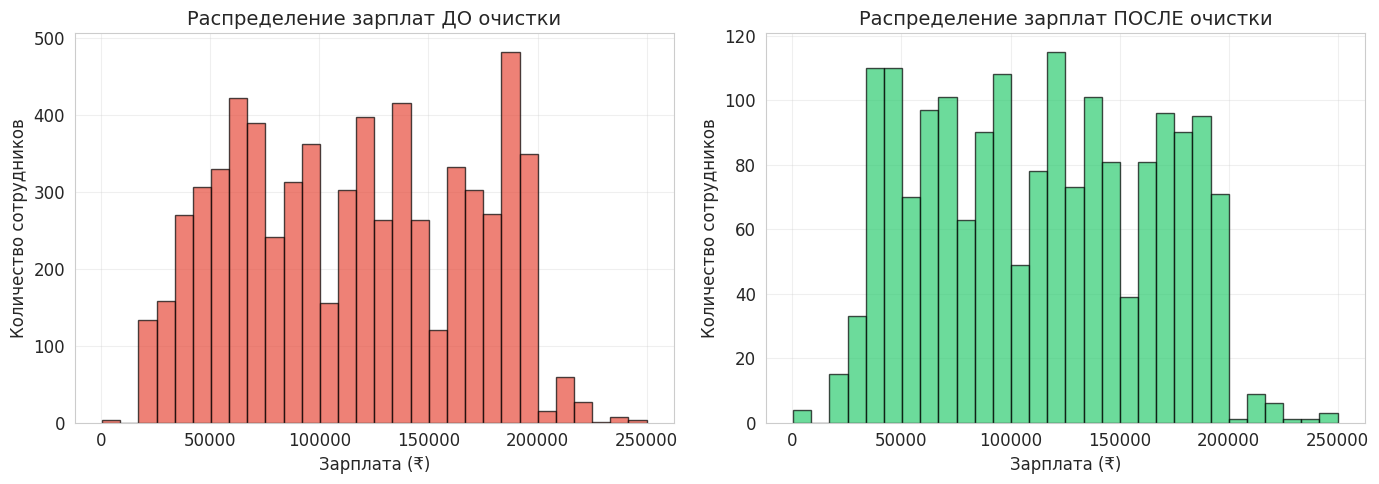


Создание графика 2: Зарплата по уровню образования


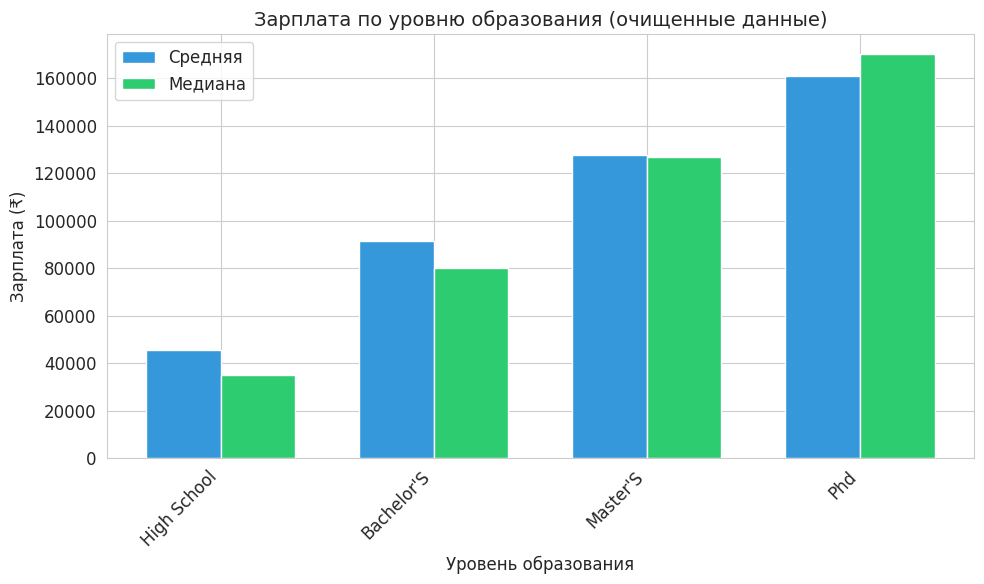


Создание графика 3: Топ-15 должностей по количеству


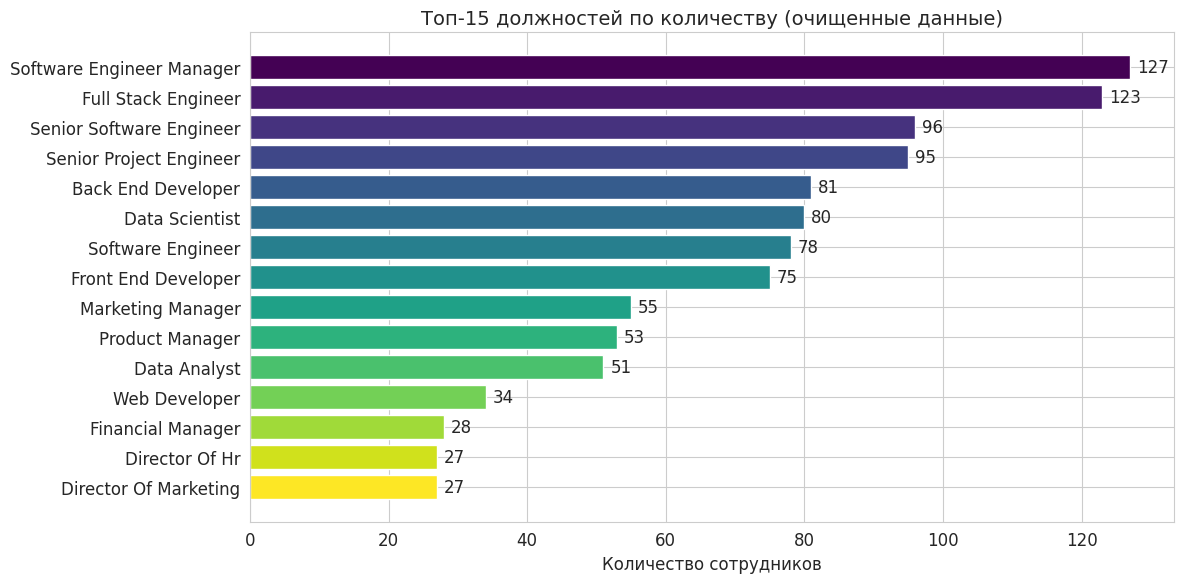


Создание графика 4: Топ-10 должностей по средней зарплате


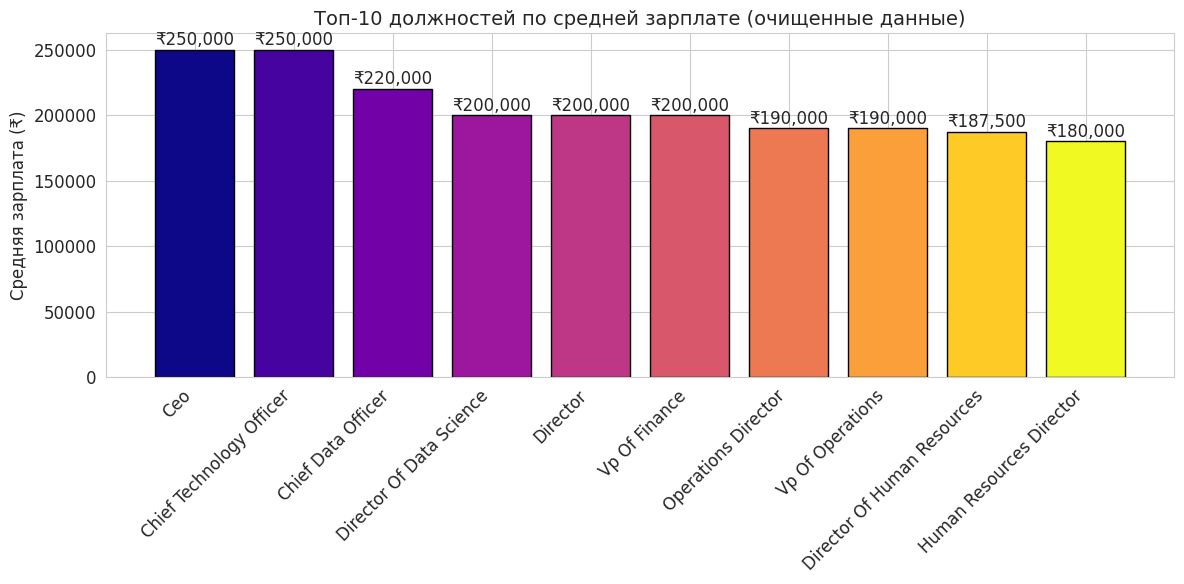


Создание графика 5: Зависимость зарплаты от возраста


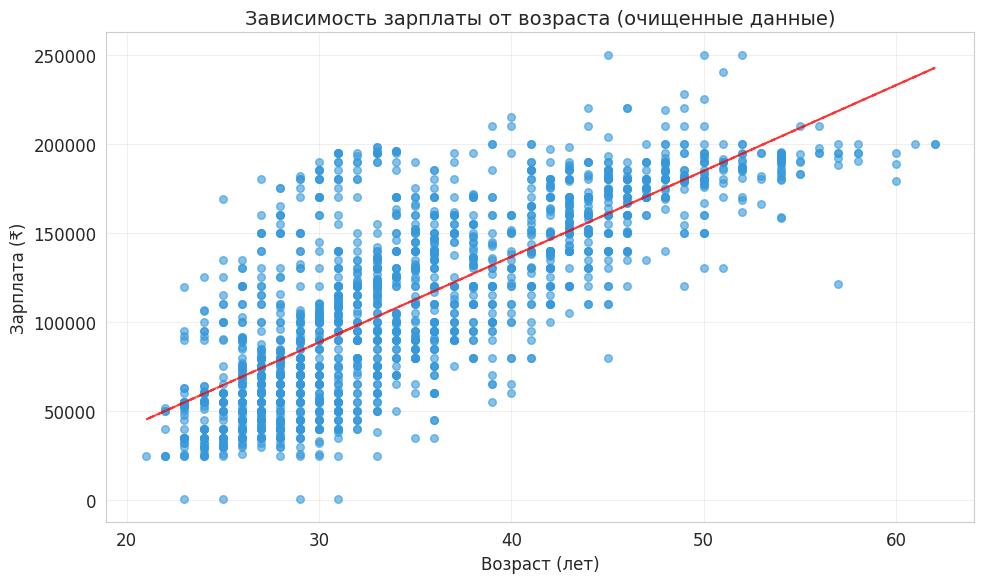


Создание графика 6: Предсказанные vs Фактические значения


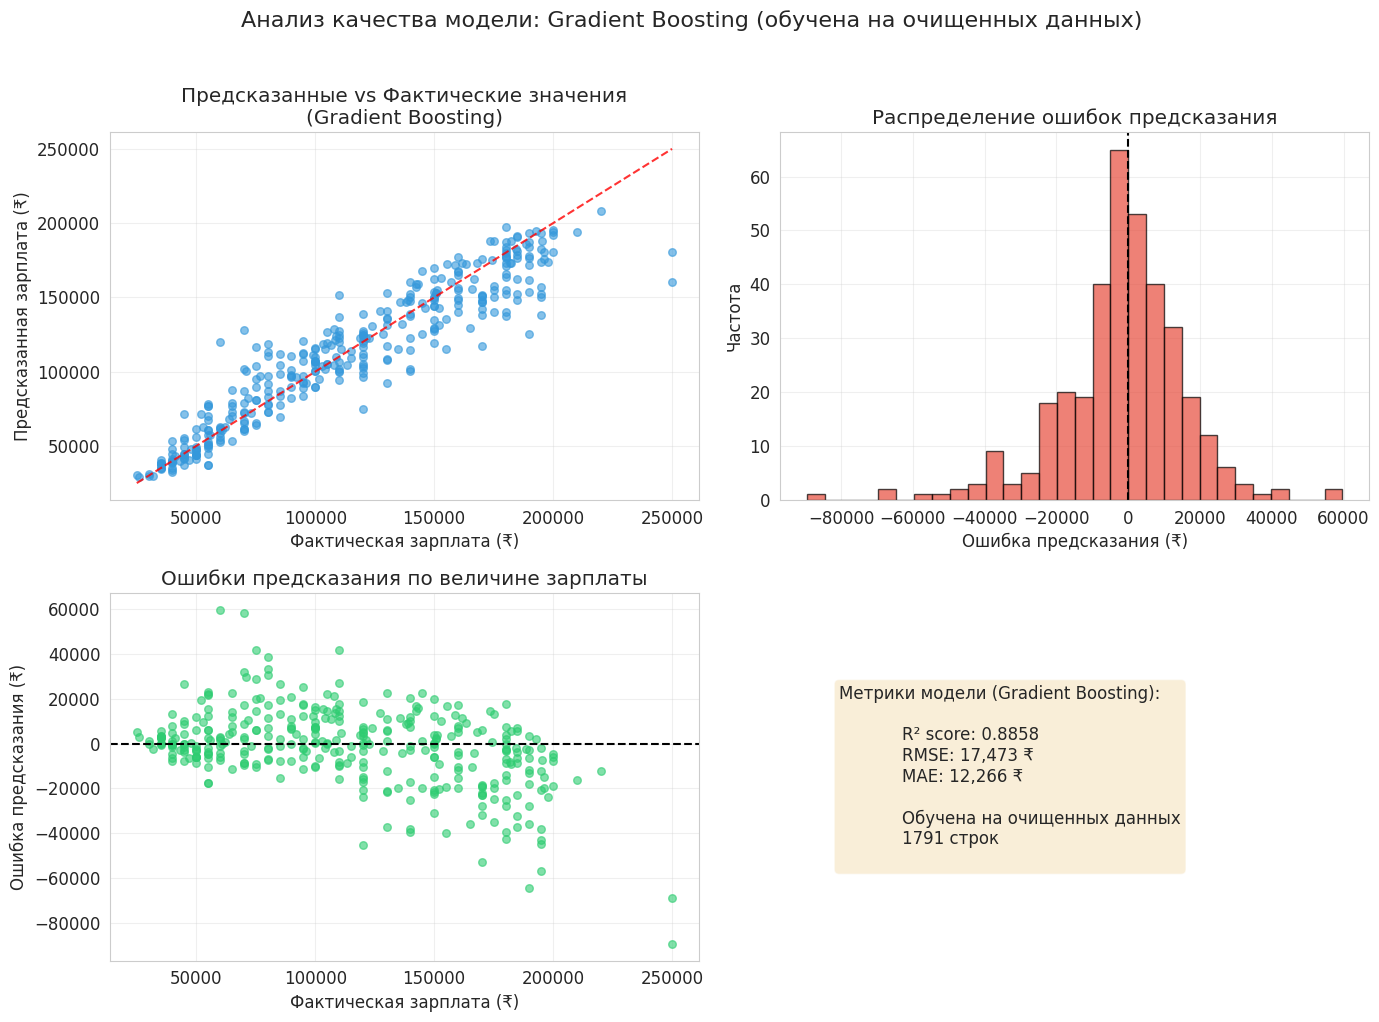


Все графики успешно созданы и будут отображаться на GitHub!

ПАЙПЛАЙН УСПЕШНО ЗАВЕРШЕН!
Использовано очищенных данных: 1791 строк (из 6704 исходных)
Очищенные данные сохранены в: Salary_Data.csv
Обученная модель сохранена: /content/results/trained_model.pkl
Модели обучены на очищенных данных
Графики построены на очищенных данных (сравнение с сырыми)
Графики созданы с помощью matplotlib
Модель готова к использованию для прогнозирования в Streamlit

Пайплайн успешно завершен!
Результаты сохранены в /content/results/


In [6]:
# Запускаем пайплайн
import sys
sys.path.append('/content')
from run_pipeline import run_pipeline

print("Начинаю выполнение пайплайна...")
results = run_pipeline()

if results:
    print("\nПайплайн успешно завершен!")
    print("Результаты сохранены в /content/results/")
else:
    print("\nПайплайн завершился с ошибкой")
    print("Проверьте настройку Kaggle API или наличие данных")

In [7]:
# ЗАПУСК STREAMLIT ПРИЛОЖЕНИЯ
print("\n" + "=" * 70)
print("ЗАПУСК STREAMLIT ПРИЛОЖЕНИЯ")
print("=" * 70)

import subprocess
import threading
import time
from google.colab.output import eval_js

def run_streamlit():
    subprocess.run([
        "streamlit", "run", "streamlit_app.py",
        "--server.port", "8501",
        "--server.headless", "true",
        "--server.enableCORS", "false"
    ])

# Запуск в отдельном потоке
thread = threading.Thread(target=run_streamlit)
thread.start()

# Дайте время на запуск
time.sleep(3)

# Получите URL
print(f"\nStreamlit приложение запущено!")
print(f"Откройте: {eval_js('google.colab.kernel.proxyPort(8501)')}")


ЗАПУСК STREAMLIT ПРИЛОЖЕНИЯ

Streamlit приложение запущено!
Откройте: https://8501-m-s-48po8j6i6a0l-c.us-central1-2.prod.colab.dev
